In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()

Dataset ./data/extract - cash request - data analyst.csv cargado correctamente.
Dimensiones del dataset cr: (23970, 16)
Columnas: ['id', 'amount', 'status', 'created_at', 'updated_at', 'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date', 'cash_request_received_date', 'money_back_date', 'transfer_type', 'send_at', 'recovery_status', 'reco_creation', 'reco_last_update']
Dataset ./data/extract - fees - data analyst - .csv cargado correctamente.
Dimensiones del dataset fe: (21061, 13)
Columnas: ['id', 'cash_request_id', 'type', 'status', 'category', 'total_amount', 'reason', 'created_at', 'updated_at', 'paid_at', 'from_date', 'to_date', 'charge_moment']
Lista de dataframes: ['cr', 'fe', 'ex', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall', 'df_hyper']
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --

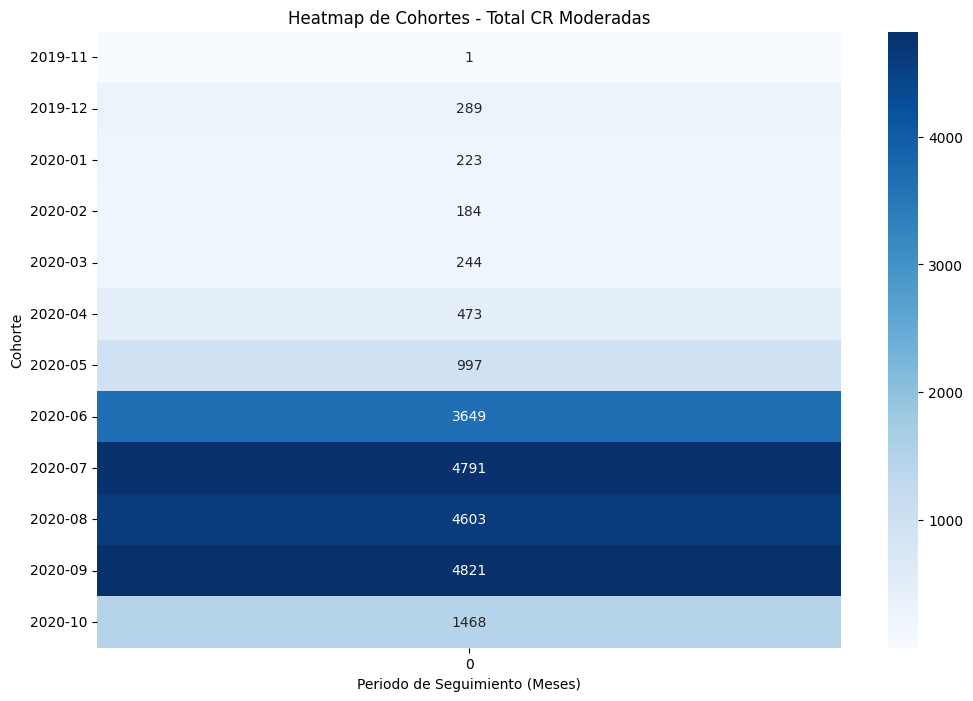

In [18]:
import pandas as pd
import numpy as np

# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Asegúrate de que ambas columnas sean del tipo datetime
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])

# 1. Definir la Cohorte
df_jo['Cohorte'] = df_jo['Mes_created_at']

# 2. Calcular el Periodo de Seguimiento basado en la diferencia entre created_at y la cohorte
df_jo['Periodo_seguimiento'] = (
    (df_jo['created_at'].dt.year - df_jo['Cohorte'].dt.year) * 12 +
    (df_jo['created_at'].dt.month - df_jo['Cohorte'].dt.month)
)

# 3. Filtrar registros con Periodo_seguimiento >= 0 (evitar valores negativos)
df_jo = df_jo[df_jo['Periodo_seguimiento'] >= 0]

# 4. Definir los valores 'good' para las métricas
cr_status_good_values = ['approved', 'money_sent', 'pending', 'direct_debit_sent', 'active', 'money_back']
fe_status_good_values = ['confirmed', 'accepted', 'cr_regular']
recov_status_good_values = ['nice', 'pending']

# 5. Agrupar por Cohorte y Periodo_seguimiento para calcular métricas
cohort_data = df_jo.groupby(['Cohorte', 'Periodo_seguimiento']).agg(
    total_cr_moderadas=('moderated_at', lambda x: x.notnull().sum()),
    total_cr_status_good=('stat_cr', lambda x: x.isin(cr_status_good_values).sum()),
    total_fe_status_good=('stat_fe', lambda x: x.isin(fe_status_good_values).sum()),
    total_recov_status_good=('recovery_status', lambda x: x.isin(recov_status_good_values).sum())
).reset_index()

# 6. Pivotear la tabla para crear el heatmap
heatmap_data = cohort_data.pivot(
    index='Cohorte',
    columns='Periodo_seguimiento',
    values='total_cr_moderadas'  # Cambia por la métrica que quieras visualizar
)

# 7. Graficar el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="g", cmap="Blues")
plt.title("Heatmap de Cohortes - Total CR Moderadas")
plt.xlabel("Periodo de Seguimiento (Meses)")
plt.ylabel("Cohorte")
plt.show()



In [14]:
cohort_data

,Cohorte,Periodo_seguimiento,total_cr_moderadas,total_cr_status_good,total_fe_status_good,total_recov_status_good
0,2019-11,0,1,0,1,1
1,2019-12,0,289,155,289,274
2,2020-01,0,223,102,223,199
3,2020-02,0,184,102,184,178
4,2020-03,0,244,166,244,228
5,2020-04,0,473,309,472,428
6,2020-05,0,997,737,844,814
7,2020-06,0,3649,2429,2858,2972
8,2020-07,0,4791,2846,3755,4057
9,2020-08,0,4603,3530,4081,4179


In [7]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

cr_status_good_values = ['approved', 'money_sent', 'pending', 'direct_debit_sent', 'active', 'money_back']
fe_status_good_values = ['confirmed', 'accepted', 'cr_regular']
recov_status_good_values = ['nice','pending']

monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de CR moderadas
    total_cr_moderadas=('moderated_at', lambda x: x.notnull().sum()),
    # Calcular total de CR con status "good"
    total_cr_status_good=('stat_cr', lambda x: x.isin(cr_status_good_values).sum()),
    total_fe_status_good=('stat_fe', lambda x: x.isin(fe_status_good_values).sum()),
    total_recov_status_good = ('recovery_status', lambda x: x.isin(recov_status_good_values).sum())
).reset_index()

monthly_data['Cohorte']=monthly_data['Mes_created_at']
monthly_data

,Mes_created_at,total_cr_moderadas,total_cr_status_good,total_fe_status_good,total_recov_status_good,Cohorte
0,2019-11,1,0,1,1,2019-11
1,2019-12,289,155,289,274,2019-12
2,2020-01,223,102,223,199,2020-01
3,2020-02,184,102,184,178,2020-02
4,2020-03,244,166,244,228,2020-03
5,2020-04,473,309,472,428,2020-04
6,2020-05,997,737,844,814,2020-05
7,2020-06,3649,2429,2858,2972,2020-06
8,2020-07,4791,2846,3755,4057,2020-07
9,2020-08,4603,3530,4081,4179,2020-08


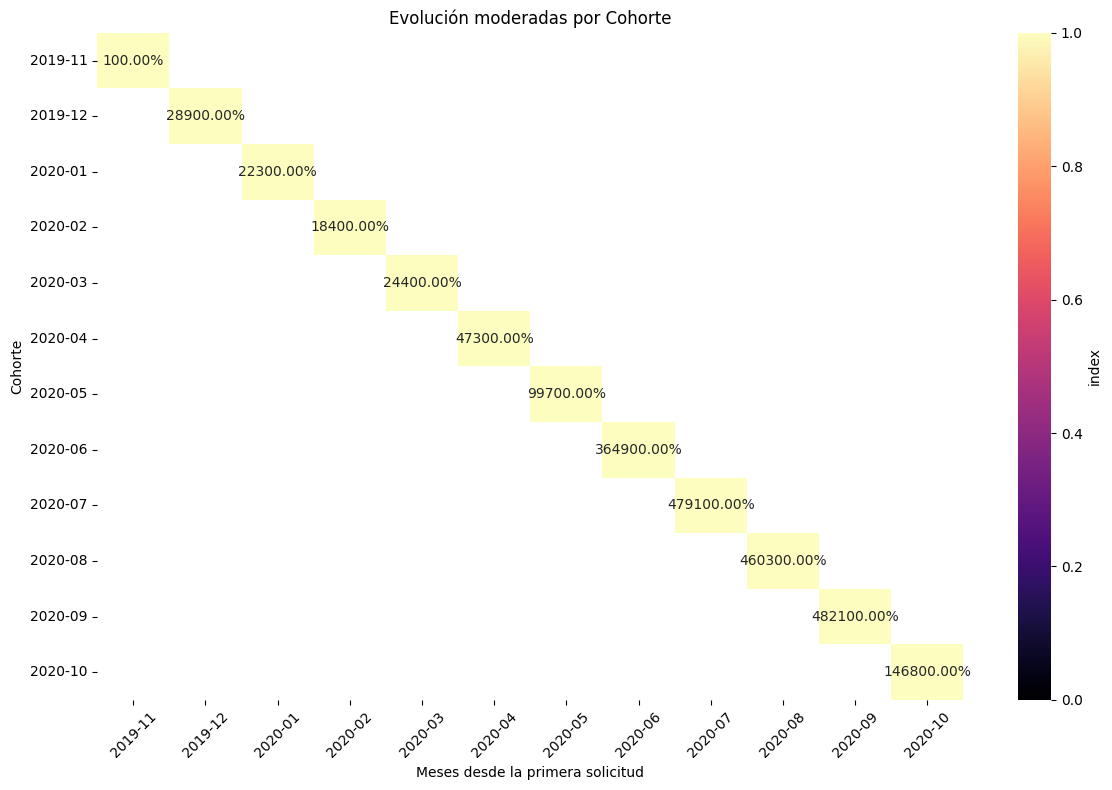

In [9]:
# Pivotar los datos para crear una matriz de index por cohorte para cada mes
cohorte_heatmap_data = monthly_data.pivot(index='Cohorte', columns='Mes_created_at', values='total_cr_moderadas')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohorte_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='magma', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución moderadas por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()

In [ ]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
df_jo

,id_cr,id_fe,fe_cr_id,user_id,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,...,charge_moment,moderated_at,reason,category,from_date,to_date,recovery_status,Mes_created_at,cash_request_received_date,Cohorte
0,5,0,NaN,804,2019-12-10 19:05:21.596873,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 16:47:42.405646,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
1,70,0,NaN,231,2019-12-10 19:50:12.347780,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 14:24:22.897988,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
2,7,0,NaN,191,2019-12-10 19:13:35.825460,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 09:46:59.777728,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
3,10,0,NaN,761,2019-12-10 19:16:10.880172,NaT,99.0,NaN,rejected,NaN,...,NaN,2019-12-18 14:26:18.128407,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
4,1594,0,NaN,7686,2020-05-06 09:59:38.877376,NaT,100.0,NaN,rejected,NaN,...,NaN,2020-05-07 09:21:55.320193,NaN,NaN,NaT,NaT,nice,2020-05,NaT,2020-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,22357,15041,22357.0,82122,2020-10-20 07:58:04.006937,2020-10-20 07:58:19.637461,100.0,5.0,money_back,accepted,...,after,NaT,Instant Payment Cash Request 22357,nice,NaT,NaT,nice,2020-10,2020-10-21,2020-10
32088,20256,20325,20256.0,64517,2020-10-10 05:40:55.700422,2020-10-30 17:08:16.906449,100.0,5.0,money_back,accepted,...,before,NaT,Postpone Cash Request 20256,nice,2020-11-06 11:00:00,2020-12-07 11:00:00,nice,2020-10,2020-10-12,2020-10
32089,20256,12366,20256.0,64517,2020-10-10 05:40:55.700422,2020-10-10 05:42:11.679401,100.0,5.0,money_back,accepted,...,after,NaT,Instant Payment Cash Request 20256,nice,NaT,NaT,nice,2020-10,2020-10-12,2020-10
32090,19886,12513,19886.0,44867,2020-10-08 14:16:52.155661,2020-10-10 21:22:00.083739,100.0,5.0,direct_debit_sent,accepted,...,before,NaT,Postpone Cash Request 19886,nice,2020-11-06 22:00:00,2020-12-06 11:00:00,nice,2020-10,2020-10-10,2020-09


In [ ]:
# Calcular métricas mensuales para ver morosidad
cohort_risk_data = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    # Sumar los valores de 'fee' donde 'stat_fe' es igual a 'accepted'
    total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
    # Calcular total de fees que no han sido cobradas
    #total_non_paid_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['rejected', 'cancelled'])].unique().sum()),
    # Calcular total de fees que han sido fallidas (rejected y cancelled)
    total_confirmed_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['confirmed'])].sum()),
    
    # Calcular total de adelantos enviados, donde 'cash_request_received_date' no es nulo (ha sido recibido por el cliente)
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'stat_fe' != 'cancelled'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'cancelled'].sum()),
    # Calcular total de amount de cash_request adelantados donde 'status_cr' != 'money_back' y != 'active'
    total_cr_non_reimbur=('amount', lambda x: x[
        (df_jo.loc[x.index, 'stat_cr'] != 'money_back') & 
        (df_jo.loc[x.index, 'stat_cr'] != 'active') &
        (df_jo.loc[x.index, 'cash_request_received_date'].notnull())]
    .sum()   
    )
).reset_index()

cohort_risk_data['total_non_paid_fees'] = cohort_risk_data['total_fees'] - cohort_risk_data['total_paid_fees']
cohort_risk_data['non_paid_fees_percent']= (cohort_risk_data['total_non_paid_fees']/cohort_risk_data['total_fees'])
cohort_risk_data['non_paid_cr_percent']= (cohort_risk_data['total_cr_non_reimbur']/cohort_risk_data['total_adelantos'])


cohort_risk_data

,Cohorte,Mes_created_at,total_paid_fees,total_confirmed_fees,total_adelantos,total_fees,total_cr_non_reimbur,total_non_paid_fees,non_paid_fees_percent,non_paid_cr_percent
0,2019-11,2019-11,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2019-11,2019-12,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2019-11,2020-04,0.0,0.0,100.0,0.0,0.0,0.0,NaN,0.000000
3,2019-11,2020-05,5.0,0.0,10.0,5.0,0.0,0.0,0.000000,0.000000
4,2019-11,2020-08,10.0,0.0,10.0,10.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
68,2020-08,2020-09,1265.0,5.0,16170.0,1370.0,3450.0,105.0,0.076642,0.213358
69,2020-08,2020-10,1150.0,0.0,17330.0,1195.0,680.0,45.0,0.037657,0.039238
70,2020-09,2020-09,8215.0,5.0,98731.0,8875.0,19690.0,660.0,0.074366,0.199431
71,2020-09,2020-10,3175.0,5.0,40810.0,3440.0,3760.0,265.0,0.077035,0.092134


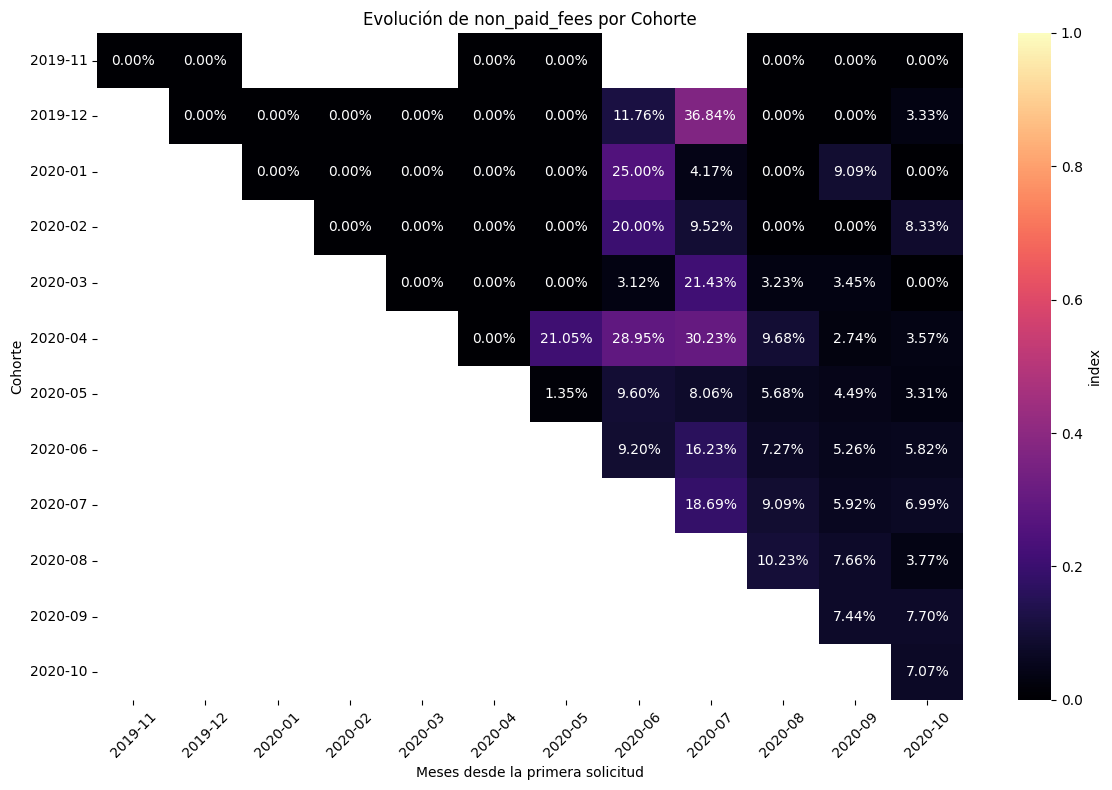

In [ ]:
cohort_risk_data.fillna(0, inplace=True)

# Pivotar los datos para crear una matriz de index por cohorte para cada mes
non_paid_fees_heatmap_data = cohort_risk_data.pivot(index='Cohorte', columns='Mes_created_at', values='non_paid_fees_percent')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(non_paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='magma', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de non_paid_fees por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


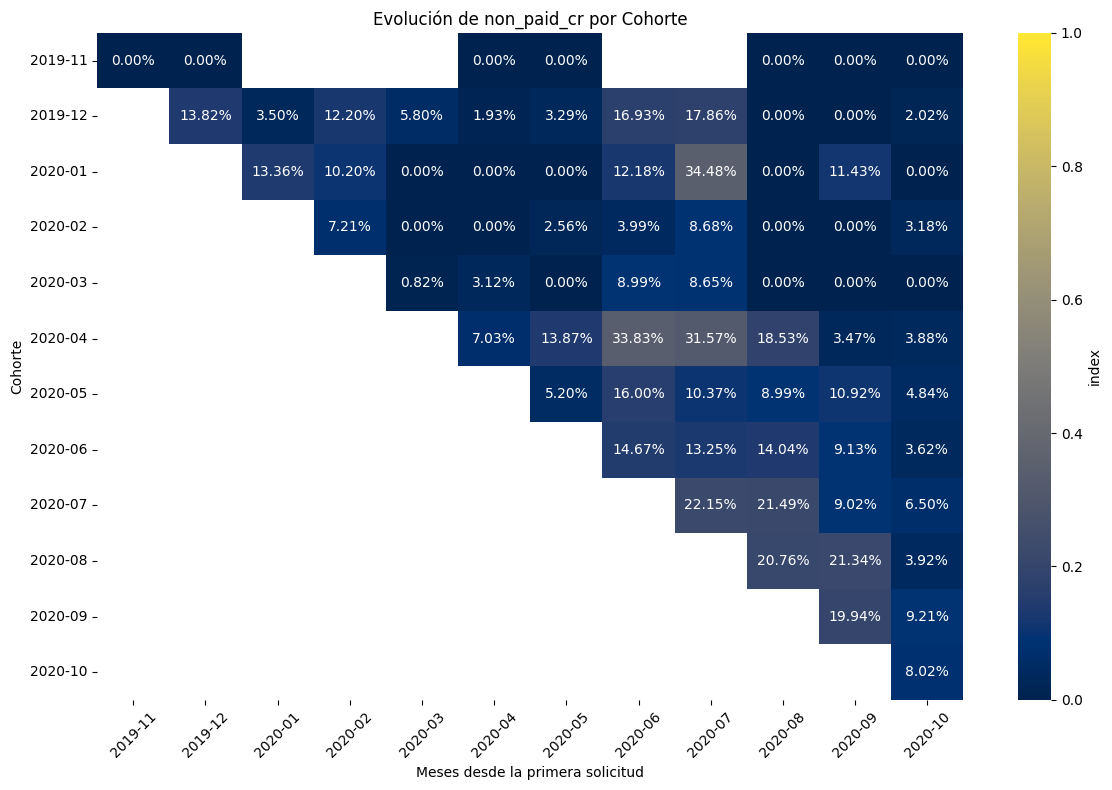

In [ ]:
cohort_risk_data.fillna(0, inplace=True)

# Pivotar los datos para crear una matriz de index por cohorte para cada mes
non_paid_fees_heatmap_data = cohort_risk_data.pivot(index='Cohorte', columns='Mes_created_at', values='non_paid_cr_percent')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(non_paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='cividis', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de non_paid_cr por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()

In [ ]:
# Filter for Cohorte '2020-04' and calculate unique id_cr sums per user and month
cr_non_paid_2020_04 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-04') &  # Filter cohort
        (df_jo['stat_cr'] != 'money_back') & 
        (df_jo['stat_cr'] != 'active') &
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)

# Filtrar los 10 peores usuarios por el total de amount
cohort_amount_2020_04_worst10 = cr_non_paid_2020_04.sort_values(by='amount', ascending=False).head(10)

# Pivot to show months as columns
cohort_amount_2020_04_worst10 = cohort_amount_2020_04_worst10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_04_worst10



Mes_created_at,2020-04,2020-05,2020-06,2020-07,2020-08
user_id,,,,,
2860,100.0,NaN,NaN,NaN,NaN
4552,NaN,100.0,100.0,NaN,NaN
4723,100.0,NaN,NaN,NaN,NaN
4869,NaN,NaN,NaN,100.0,NaN
4906,NaN,NaN,NaN,NaN,100.0
4973,NaN,NaN,NaN,NaN,100.0
5015,NaN,NaN,100.0,NaN,NaN
5185,100.0,NaN,NaN,NaN,NaN
5241,100.0,NaN,NaN,NaN,NaN


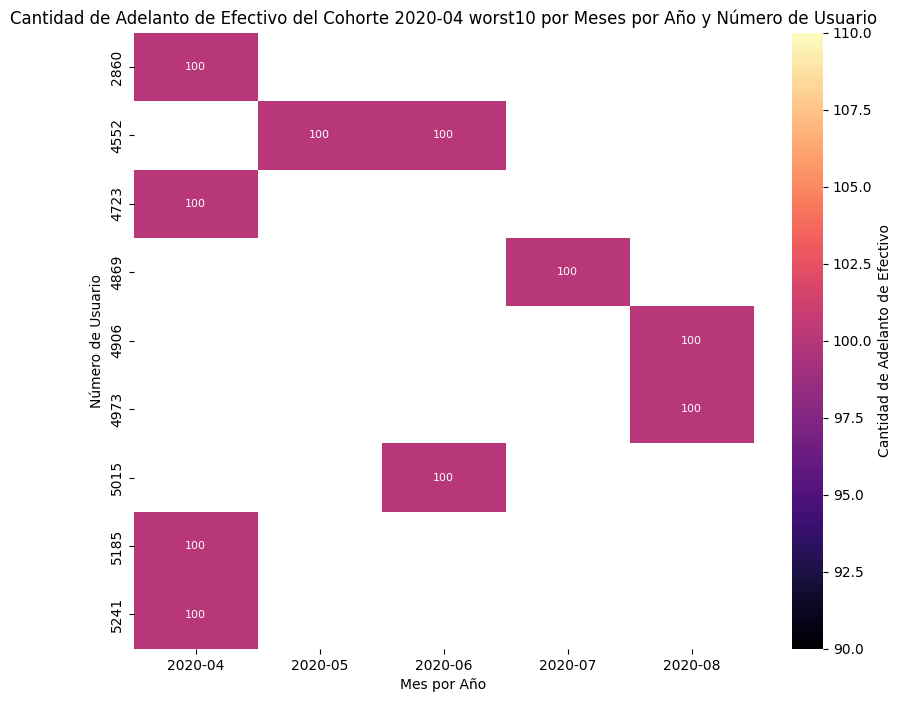

In [ ]:
# Graficar la cantidad de adelanto de efectivo de la cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-04 worst10 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_04_worst10, annot=True, fmt='.0f', cmap='magma', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [ ]:
# Filter for Cohorte '2020-07' and calculate unique id_cr sums per user and month
cr_non_paid_2020_07 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-07') &  # Filter cohort
        (df_jo['stat_cr'] != 'money_back') & 
        (df_jo['stat_cr'] != 'active') &
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)

# Filtrar los 10 peores usuarios por el total de amount
cohort_amount_2020_07_worst10 = cr_non_paid_2020_07.sort_values(by='amount', ascending=False).head(10)

# Pivot to show months as columns
cohort_amount_2020_07_worst10 = cohort_amount_2020_07_worst10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_07_worst10

Mes_created_at,2020-07,2020-08,2020-10
user_id,,,
4305,100.0,NaN,NaN
5206,100.0,NaN,NaN
5223,NaN,NaN,100.0
6765,NaN,100.0,NaN
8866,NaN,100.0,NaN
11657,NaN,100.0,NaN
11832,NaN,NaN,100.0
12699,100.0,NaN,NaN
12710,100.0,NaN,NaN


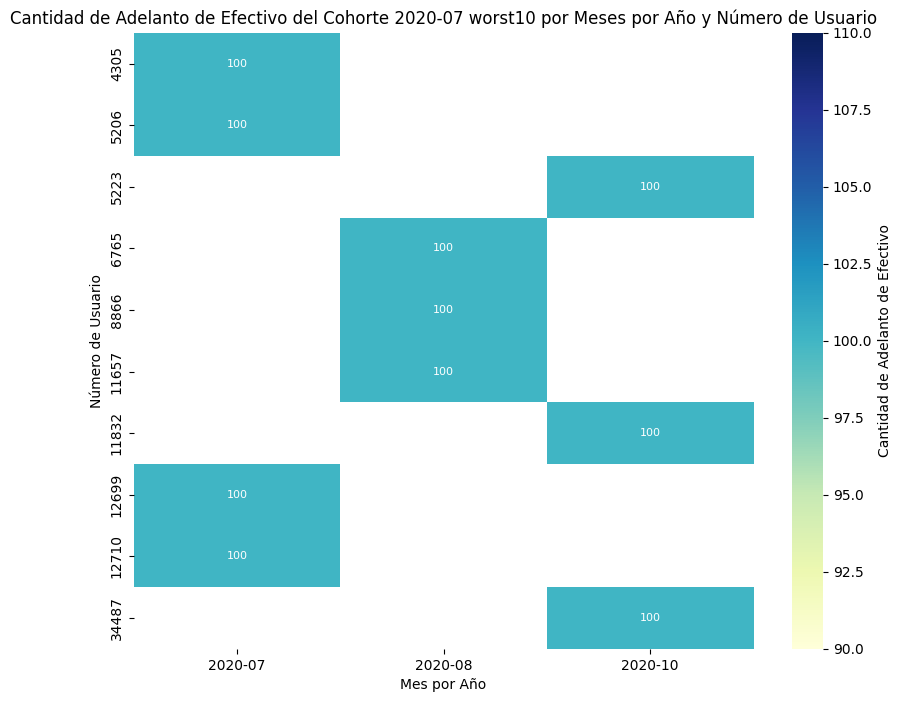

In [ ]:
# Graficar la cantidad de adelanto de efectivo de la cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-07 worst10 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_07_worst10, annot=True, fmt='.0f', cmap='YlGnBu', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()